In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [5]:
from models.lpn import LPN
from models.encoder import IOPairSetEncoder
from models.decoder import Decoder
from models.utils import ReluNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
numstep = 1
d_latent = 2

encoder = IOPairSetEncoder(phi=ReluNet(2, 16, 32),
                           rho_0=ReluNet(32, 16, 16),
                           rho_1=ReluNet(16, 8, d_latent))

decoder = Decoder(d_input=1, d_latent=d_latent, ds_hidden=[16, 16, 16], d_output=1)

lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)
state_dict = torch.load(f'lpn_H{d_latent}_GA{numstep}_cmp.pth')
lpn.load_state_dict(state_dict, strict=False)

lpn.eval()

LPN(
  (encoder): IOPairSetEncoder(
    (phi): ReluNet(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=32, bias=True)
      )
    )
    (rho_0): ReluNet(
      (net): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=16, bias=True)
      )
    )
    (rho_1): ReluNet(
      (net): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=2, bias=True)
      )
    )
    (rho_2): ReluNet(
      (net): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=2, bias=True)
      )
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2)

In [8]:
from torch import Tensor
from models.lpn import make_leave_one_out
from sine_data_generator import SineDataGenerator

samples = 10

data_gen = SineDataGenerator(num_samples_per_class=samples, batch_size=2)

xs, ys, amp, phase = data_gen.generate()
io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)

leave_one_out = make_leave_one_out(io_pairs, axis=1) 

left_one_out = io_pairs[:, :, 0].unsqueeze(-1)
left_one_out_y_true = io_pairs[:, :, 1].unsqueeze(-1)

z_mu, z_logvar = encoder(leave_one_out)

In [10]:
amp

tensor([0.3446, 1.8291])

In [11]:
print(left_one_out.size(), left_one_out_y_true.size())
z_mu, z_mu.size()

torch.Size([2, 10, 1]) torch.Size([2, 10, 1])


(tensor([[[0.0494, 0.5773],
          [0.0474, 0.5700],
          [0.0510, 0.5758],
          [0.0564, 0.5866],
          [0.0449, 0.5763],
          [0.0513, 0.5769],
          [0.0489, 0.5746],
          [0.0486, 0.5771],
          [0.0515, 0.5749],
          [0.0472, 0.5707]],
 
         [[0.2770, 0.5280],
          [0.2623, 0.5694],
          [0.2444, 0.5512],
          [0.2962, 0.5445],
          [0.2941, 0.5516],
          [0.2709, 0.5582],
          [0.2757, 0.5317],
          [0.2975, 0.5397],
          [0.2651, 0.5575],
          [0.2732, 0.5629]]], grad_fn=<ViewBackward0>),
 torch.Size([2, 10, 2]))

In [12]:
z_xs = torch.cat([z_mu, left_one_out], dim=-1)
print(z_xs.size())
print(z_xs)

left_one_out_y_pred = decoder(z_xs)

left_one_out_y_true, left_one_out_y_pred

torch.Size([2, 10, 3])
tensor([[[ 0.0494,  0.5773,  1.7548],
         [ 0.0474,  0.5700, -2.5254],
         [ 0.0510,  0.5758,  0.7728],
         [ 0.0564,  0.5866, -0.7910],
         [ 0.0449,  0.5763,  2.1446],
         [ 0.0513,  0.5769, -1.0691],
         [ 0.0489,  0.5746, -4.1140],
         [ 0.0486,  0.5771,  1.8229],
         [ 0.0515,  0.5749, -4.8467],
         [ 0.0472,  0.5707, -2.3520]],

        [[ 0.2770,  0.5280,  1.0252],
         [ 0.2623,  0.5694, -3.4615],
         [ 0.2444,  0.5512, -0.0173],
         [ 0.2962,  0.5445, -1.4128],
         [ 0.2941,  0.5516,  1.3450],
         [ 0.2709,  0.5582,  3.1897],
         [ 0.2757,  0.5317,  4.1527],
         [ 0.2975,  0.5397, -1.9336],
         [ 0.2651,  0.5575, -2.7900],
         [ 0.2732,  0.5629,  2.6518]]], grad_fn=<CatBackward0>)


(tensor([[[-0.0440],
          [ 0.3288],
          [-0.3087],
          [-0.1553],
          [ 0.0892],
          [-0.0649],
          [ 0.0973],
          [-0.0207],
          [-0.1488],
          [ 0.3061]],
 
         [[-0.8213],
          [ 1.7767],
          [-1.8255],
          [-0.4312],
          [-0.2657],
          [ 1.8141],
          [ 0.8442],
          [ 0.5105],
          [ 1.6614],
          [ 1.6776]]]),
 tensor([[[ 0.0860],
          [ 0.0019],
          [ 0.1950],
          [-0.0578],
          [ 0.2682],
          [-0.0950],
          [ 0.3133],
          [ 0.1178],
          [-0.1446],
          [-0.1455]],
 
         [[-1.0497],
          [ 1.4776],
          [-1.5926],
          [-0.0337],
          [-0.7138],
          [ 1.8209],
          [ 0.9400],
          [ 0.8426],
          [ 1.6778],
          [ 1.3408]]], grad_fn=<ViewBackward0>))

In [13]:
from torch import Tensor

resolution = 300j

grid2d = Tensor(np.mgrid[-5:5:resolution, -5:5:resolution].reshape(2, 1, -1).T)
print(grid2d, grid2d.size())
print(left_one_out, left_one_out.size())

shape_expand = [max(x,y) for x,y in zip(grid2d.size()[:-1], left_one_out.size()[:-1])]
grid2d = grid2d.expand(shape_expand + [grid2d.size()[-1]])
left_one_out = left_one_out.expand(shape_expand + [left_one_out.size()[-1]])
z_xs = torch.cat([grid2d, left_one_out], dim=-1)
z_xs, z_xs.size()

tensor([[[-5.0000, -5.0000]],

        [[-5.0000, -4.9666]],

        [[-5.0000, -4.9331]],

        ...,

        [[ 5.0000,  4.9331]],

        [[ 5.0000,  4.9666]],

        [[ 5.0000,  5.0000]]]) torch.Size([90000, 1, 2])
tensor([[[ 1.7548],
         [-2.5254],
         [ 0.7728],
         [-0.7910],
         [ 2.1446],
         [-1.0691],
         [-4.1140],
         [ 1.8229],
         [-4.8467],
         [-2.3520]],

        [[ 1.0252],
         [-3.4615],
         [-0.0173],
         [-1.4128],
         [ 1.3450],
         [ 3.1897],
         [ 4.1527],
         [-1.9336],
         [-2.7900],
         [ 2.6518]]]) torch.Size([2, 10, 1])


RuntimeError: The expanded size of the tensor (90000) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [90000, 10, 1].  Tensor sizes: [2, 10, 1]

In [ ]:
# outputs_pred: (B, N, 1)
mse = nn.MSELoss(reduction='none')
left_one_out_y_pred = decoder(z_xs)

X_pred = torch.cat([z_xs, left_one_out_y_pred], dim=-1)
X_true = torch.cat([z_xs, left_one_out_y_true.expand_as(left_one_out_y_pred)], dim=-1)
print(X_pred.size(), X_true.size())

X_mse = (X_pred[:, :, 3]- X_true[:, :, 3])**2
print(X_mse.size())

In [ ]:
X_pred[:,:,:2].size(), X_mse.unsqueeze(-1).size()

In [ ]:
X_cat = torch.cat([X_pred[:,:,:2], X_mse.unsqueeze(-1)], dim=-1)
X_cat = X_cat.detach().cpu().numpy()
print(X_cat.shape)

# Plotting
def plot_2d_log(X_cat, z_mu=None, sample=0):
    X = X_cat[:, sample, :2]
    Y = X_cat[:, sample, 2]
    init_z = z_mu[:, sample, :].detach().cpu().numpy() if z_mu is not None else None
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=np.log(Y), s=5)
    if z_mu is not None:
        plt.scatter(init_z[:, 0], init_z[:, 1], c='red', s=5, alpha=0.5)
    plt.colorbar()
    plt.show()

def plot_2d(X, Y, z_mu=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=5)
    plt.colorbar()
    plt.show()

In [ ]:
print(z_mu)
sample = 1
init_z = z_mu[:, sample, :]
init_z, init_z.size()

In [ ]:
for sample in range(samples):
    print(f"Sample {sample}")
    plot_2d_log(X_cat, sample=sample, z_mu=z_mu)

In [ ]:
io_pairs

In [ ]:
leave_one_out

In [ ]:
left_one_out, left_one_out.size()

In [16]:
# 2d grid of latent space
# concat with 

In [ ]:
from visualization import LPNVisualizer

# Initialize the visualizer
visualizer = LPNVisualizer(
    d_latent=2,
    numstep=1,
    model_path='lpn_H2_GA1_cmp.pth'  # Path to your model weights
)

# Generate and visualize samples
visualizer.make_samples(
    num_samples=10,
    resolution=300,
    log_scale=True,
)

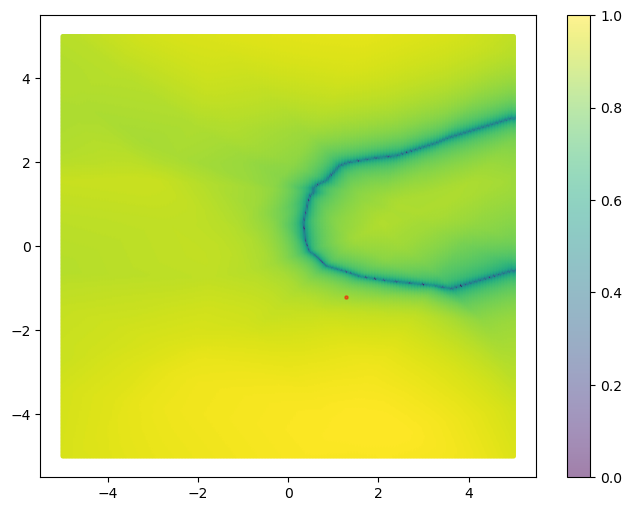

In [33]:
visualizer.plot_sample(0)